In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix', 
    'xtick.labelsize' : 13,
    'xtick.top' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.labelsize' : 13, 
    'ytick.right' : True, 
    'axes.labelsize' : 16,
    'legend.frameon': False,
    'legend.fontsize': 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600,
    'savefig.bbox' : 'tight'
})

In [2]:
print(torch.__version__)

1.7.1


In [3]:
index = ['temp', 'm']
for i in range (256):
    index.append('s%d'%i)
p = pd.read_csv('isingspin_train.txt', sep=' ', header = 0, index_col=False, names=index) # 50 * 200: training
q = pd.read_csv('isingspin_val.txt', sep=' ', header = 0, index_col=False, names=index) # 20 * 200: validation
r = pd.read_csv('isingspin_test.txt', sep=' ', header = 0, index_col=False, names=index) # 20 * 200: test
p.sort_values(by=['temp'], axis=0, inplace=True)
q.sort_values(by=['temp'], axis=0, inplace=True)
r.sort_values(by=['temp'], axis=0, inplace=True)

# info
L = 16
size = L*L
out_node = 2

train_size = 50
val_size = 20
test_size = 20

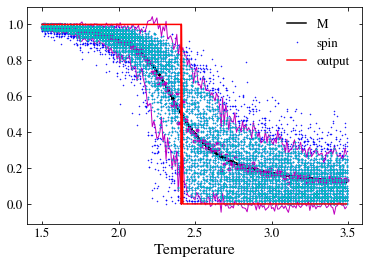

In [4]:
Tc = 2/np.log(1+np.sqrt(2))
stdev = 1.5

x1 = np.array(p[index[2:]])
y_train = np.array(p.m>=0.5, dtype=float)
y1 = torch.FloatTensor(np.stack([y_train, 1-y_train], axis=1))

plt.plot(p.temp, p.m, 'k-', label='M')
abs_x = np.abs(np.average(x1, axis=1))
plt.plot(p.temp, abs_x, 'b.', ms = 1, label='spin')

new_x = abs_x.reshape(-1, train_size)
avg_new_x = np.mean(new_x, axis=1)
std_new_x = np.std(new_x, axis=1, ddof=1)
plt.plot(np.mean(np.array(p.temp).reshape(-1, train_size), axis=1), avg_new_x, 'm.')
plt.plot(np.mean(np.array(p.temp).reshape(-1, train_size), axis=1), avg_new_x+stdev*std_new_x, 'm-', lw=1)
plt.plot(np.mean(np.array(p.temp).reshape(-1, train_size), axis=1), avg_new_x-stdev*std_new_x, 'm-', lw=1)

# trim training data out of 1.5-stdev.
upper = np.repeat(avg_new_x+stdev*std_new_x, train_size)
lower = np.repeat(avg_new_x-stdev*std_new_x, train_size)
mask = (abs_x > lower) & (abs_x < upper)
plt.plot(p.temp[mask], abs_x[mask], 'c.', ms=1)
plt.plot(p.temp, y1[:,0], 'r-', label='output')

plt.xlabel('Temperature')
plt.legend()
plt.show()

# NN with single hidden layer

In [5]:
class Net(nn.Module): 
    def __init__(self, node = None, activate = None):
        super(Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate() # activation recommanded: Sigmoid, ReLU
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        return self.sig(self.W2(self.activate(self.W1(x)+self.b1.weight.data))+self.b2.weight.data)
    
    def loss(self, output, y, reg):
        regular = reg*(torch.norm(self.W1.weight.data)+torch.norm(self.W2.weight.data)) # regularization l2
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [6]:
def Classification(func=None, h_node=None, reg = 5e-5, learning_rate = 0.001):
    
    # Data processing
    x1, x2, x3 = np.array(p[index[2:]]), np.array(q[index[2:]]), np.array(r[index[2:]])
    x1, x2, x3 = torch.FloatTensor(x1), torch.FloatTensor(x2), torch.FloatTensor(x3)
    ## output node = 2
    y_train, y_val, y_test = np.array(p.m>=0.5, dtype=float), np.array(q.m>=0.5, dtype=float), np.array(r.m>=0.5, dtype=float)
    y1, y2, y3 = np.stack([y_train, 1-y_train], axis=1), np.stack([y_val, 1-y_val], axis=1), np.stack([y_test, 1-y_test], axis=1)
    y1, y2, y3 = torch.FloatTensor(y1), torch.FloatTensor(y2), torch.FloatTensor(y3)
    x1, y1 = x1[mask], y1[mask]
    
    # create Neural Network with given activation function
    model = Net(node = h_node, activate = func)
    ## Without this process, it doesn't work well.
    if func==nn.Sigmoid: x1, x2, x3 = x1+1, x2+1, x3+1 
    print(model)
    
    # Begin training and validation
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 10000
    train_loss, val_loss = np.ones(n_epochs+1), np.ones(n_epochs+1)
    for epoch in range (n_epochs+1):
        loss = model.loss(model.forward(x1), y1, reg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        valid_loss = model.loss(model.forward(x2), y2, reg).item()
        train_loss[epoch], val_loss[epoch] = loss.item(), valid_loss

        if epoch%int(n_epochs/20) == 0:
            print('epoch = %d, training loss = %.8f, accuracy = %.8f' 
                  %(epoch, loss.item(), model.accuracy(model.forward(x1), y1)))
            plt.plot(p.temp[mask], model.forward(x1).data[:,0], '.')
            plt.xlabel('Temperature')
            plt.ylabel('output layer')
            plt.show()
        if epoch > 50:
            if valid_loss > val_loss[epoch-50]: # prevent overfitting
                print('epoch = %d, training loss = %.8f' %(epoch, loss.item()))
                plt.plot(p.temp[mask], model.forward(x1).data[:,0], '.')
                plt.xlabel('Temperature')
                plt.ylabel('output layer')
                plt.show()
                
                ax = plt.gca()
                im = ax.imshow(np.array(model.W1.weight.data), aspect=size/h_node, cmap='Spectral')
                cb = plt.colorbar(im)
                plt.show()
                break

    # record training & validation
    plt.plot(np.arange(len(train_loss)), train_loss, '-', label='train loss')
    plt.plot(np.arange(len(val_loss)), val_loss, '-', label='validation')
    plt.ylim(0, val_loss[0]+0.01)
    plt.xlim(-5, epoch-1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    # Begin test
    output = model.forward(x3).data[:,0]
    plt.plot(r.temp, r.m, 'k-')
    if func==nn.Sigmoid: plt.plot(r.temp, np.abs(np.average(x3-1, axis=1)), 'c.', ms=3, label='spin')
    else: plt.plot(r.temp, np.abs(np.average(x3, axis=1)), 'c.', ms=3, label='spin')
    plt.plot(r.temp, output, 'b.', ms=2, label='out')
    
    plt.plot(np.mean(np.array(r.temp).reshape(-1, test_size), axis=1), 
             np.mean(np.array(output).reshape(-1, test_size), axis=1), 'r.-', label='avg_out')
    plt.legend()
    plt.ylabel('output')
    plt.xlabel('Temperature')
    plt.show()
    print('test loss = %.8f, accuracy = %.8f'
          %(model.loss(model.forward(x3), y3, reg).item(), model.accuracy(model.forward(x3), y3)))
    
    return model, x3, y3

## Classification

Net(
  (W1): Linear(in_features=256, out_features=50, bias=False)
  (b1): Linear(in_features=50, out_features=1, bias=False)
  (W2): Linear(in_features=50, out_features=2, bias=False)
  (b2): Linear(in_features=2, out_features=1, bias=False)
  (activate): Sigmoid()
  (sig): Sigmoid()
)
epoch = 0, training loss = 0.69539165, accuracy = 0.62462446


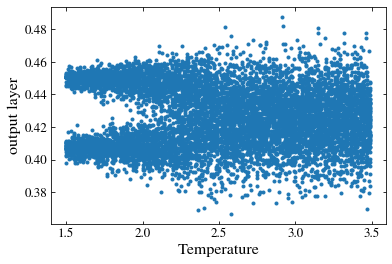

epoch = 500, training loss = 0.20007962, accuracy = 0.97079114


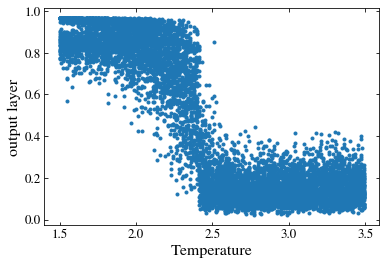

epoch = 1000, training loss = 0.07588753, accuracy = 0.99610549


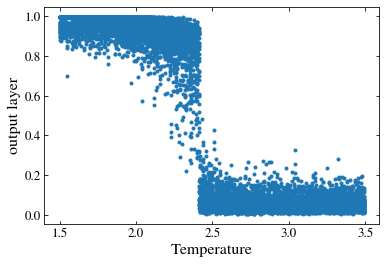

epoch = 1052, training loss = 0.06972253


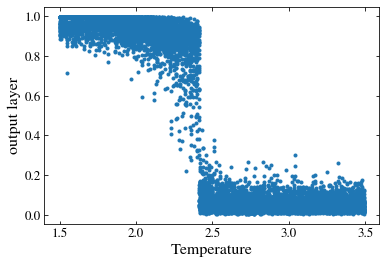

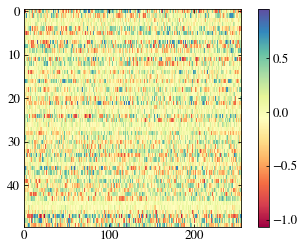

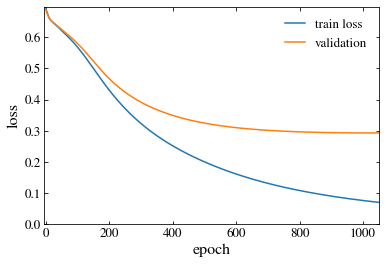

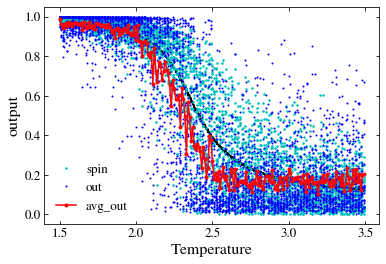

test loss = 0.28796580, accuracy = 0.89512500


In [7]:
model_sig_50 = Classification(func = nn.Sigmoid, h_node = 50)

Net(
  (W1): Linear(in_features=256, out_features=100, bias=False)
  (b1): Linear(in_features=100, out_features=1, bias=False)
  (W2): Linear(in_features=100, out_features=2, bias=False)
  (b2): Linear(in_features=2, out_features=1, bias=False)
  (activate): Sigmoid()
  (sig): Sigmoid()
)
epoch = 0, training loss = 0.74753296, accuracy = 0.54089240


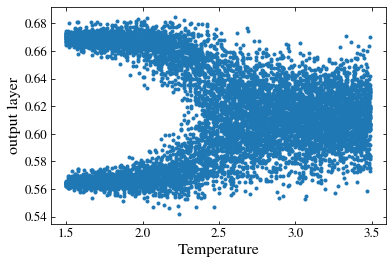

epoch = 500, training loss = 0.13804199, accuracy = 0.97234895


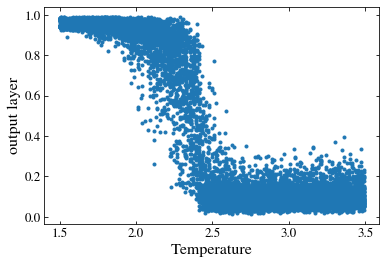

epoch = 873, training loss = 0.05965142


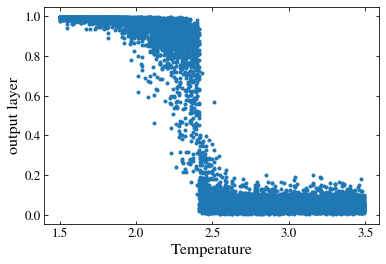

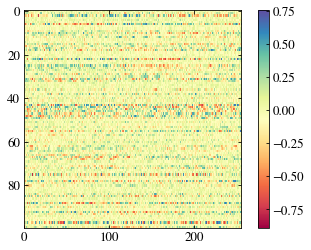

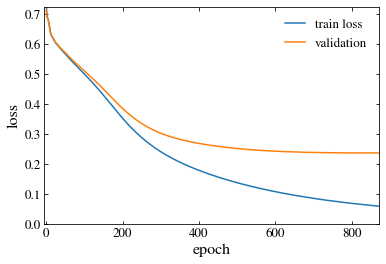

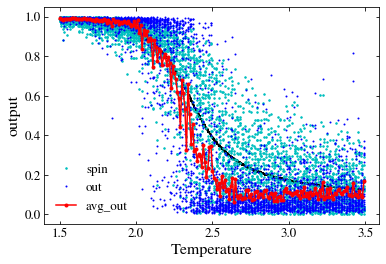

test loss = 0.23162581, accuracy = 0.92587500


In [8]:
model_sig_100 = Classification(func = nn.Sigmoid, h_node = 100)

Net(
  (W1): Linear(in_features=256, out_features=100, bias=False)
  (b1): Linear(in_features=100, out_features=1, bias=False)
  (W2): Linear(in_features=100, out_features=2, bias=False)
  (b2): Linear(in_features=2, out_features=1, bias=False)
  (activate): ReLU()
  (sig): Sigmoid()
)
epoch = 0, training loss = 0.67799830, accuracy = 0.67653277


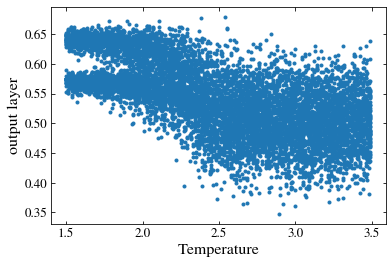

epoch = 168, training loss = 0.08956384


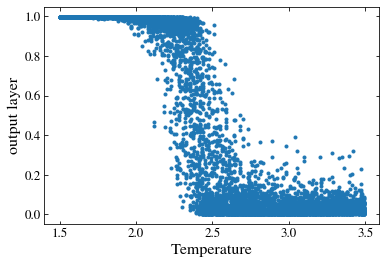

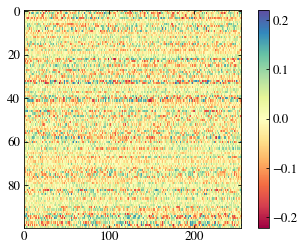

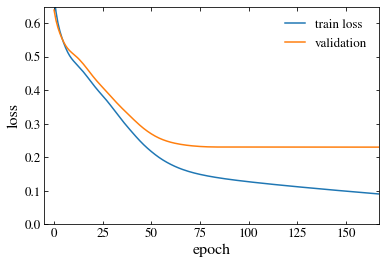

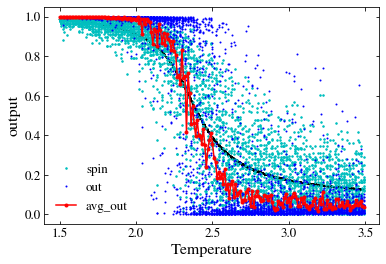

test loss = 0.21979047, accuracy = 0.92575000


In [9]:
model_relu = Classification(func = nn.ReLU, h_node = 100)

Net(
  (W1): Linear(in_features=256, out_features=100, bias=False)
  (b1): Linear(in_features=100, out_features=1, bias=False)
  (W2): Linear(in_features=100, out_features=2, bias=False)
  (b2): Linear(in_features=2, out_features=1, bias=False)
  (activate): Tanh()
  (sig): Sigmoid()
)
epoch = 0, training loss = 0.70115930, accuracy = 0.48442194


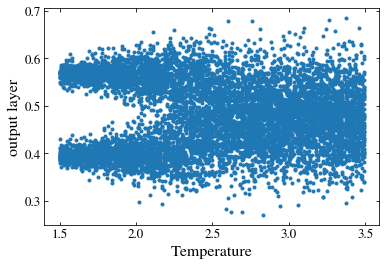

epoch = 176, training loss = 0.49134365


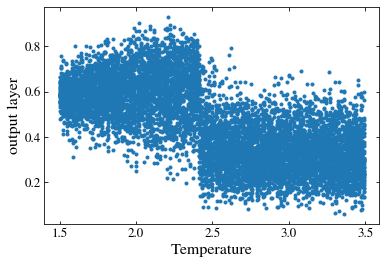

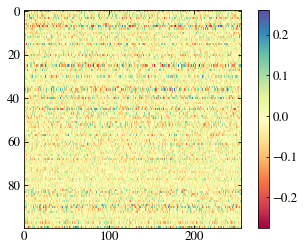

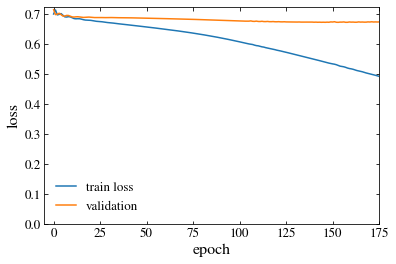

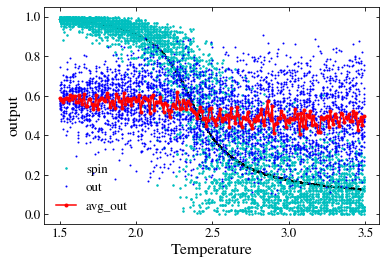

test loss = 0.66635221, accuracy = 0.63150000


In [10]:
model_tanh = Classification(func = nn.Tanh, h_node = 100)

# DNN with hidden layer 3

In [11]:
class DNet(nn.Module): # 3 hidden layer
    def __init__(self, node = None, activate = None):
        super(DNet, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, self.node, bias=False)
        self.b2 = nn.Linear(self.node, 1, bias=False)
        self.W3 = nn.Linear(self.node, self.node, bias=False)
        self.b3 = nn.Linear(self.node, 1, bias=False)
        self.W4 = nn.Linear(self.node, out_node, bias=False)
        self.b4 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        a = self.activate(self.W2(self.activate(self.W1(x)+self.b1.weight.data))+self.b2.weight.data)
        return self.sig(self.W4(self.activate(self.W3(a)+self.b3.weight.data))+self.b4.weight.data)
    
    def loss(self, output, y, reg):
        regular = reg*(torch.norm(self.W1.weight.data)+torch.norm(self.W2.weight.data))
        return F.binary_cross_entropy(output, y) + regular
    
    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [14]:
def D_Classification(func=None, h_node=None, reg = 5e-5, learning_rate = 0.001):
    
    # Data processing
    x1, x2, x3 = np.array(p[index[2:]]), np.array(q[index[2:]]), np.array(r[index[2:]])
    x1, x2, x3 = torch.FloatTensor(x1), torch.FloatTensor(x2), torch.FloatTensor(x3)
    ## output node = 2
    y_train, y_val, y_test = np.array(p.m>=0.5, dtype=float), np.array(q.m>=0.5, dtype=float), np.array(r.m>=0.5, dtype=float)
    y1, y2, y3 = np.stack([y_train, 1-y_train], axis=1), np.stack([y_val, 1-y_val], axis=1), np.stack([y_test, 1-y_test], axis=1)
    y1, y2, y3 = torch.FloatTensor(y1), torch.FloatTensor(y2), torch.FloatTensor(y3)
    x1, y1 = x1[mask], y1[mask]
    
    model = DNet(node = h_node, activate = func)
    if func==nn.Sigmoid: x1, x2, x3 = x1+1, x2+1, x3+1 
    print(model)
    
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    n_epochs = 10000
    train_loss, val_loss = np.zeros(n_epochs+1), np.zeros(n_epochs+1)
    for epoch in range (n_epochs+1):
        loss = model.loss(model.forward(x1), y1, reg)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        valid_loss = model.loss(model.forward(x2), y2, reg).item()
        train_loss[epoch], val_loss[epoch] = loss.item(), valid_loss

        if epoch%int(n_epochs/20) == 0:
            print('epoch = %d, training loss = %.8f, accuracy = %.8f' 
                  %(epoch, loss.item(), model.accuracy(model.forward(x1), y1)))
            plt.plot(p.temp[mask], model.forward(x1).data[:,0], '.')
            plt.xlabel('Temperature')
            plt.ylabel('output layer')
            plt.show()
        if epoch > 50:
            if valid_loss > val_loss[epoch-50]:
                print('epoch = %d, training loss = %.8f' %(epoch, loss.item()))
                plt.plot(p.temp[mask], model.forward(x1).data[:,0], '.')
                plt.xlabel('Temperature')
                plt.ylabel('output layer')
                plt.show()
                
                fig, ax = plt.subplots(1, 3)
                im1 = ax[0].imshow(np.array(model.W1.weight.data), aspect=size/h_node, cmap='Spectral')
                im2 = ax[1].imshow(np.array(model.W2.weight.data), aspect=1, cmap='Spectral')
                im3 = ax[2].imshow(np.array(model.W3.weight.data), aspect=1, cmap='Spectral')
                cbar_ax = fig.add_axes([0.95, 0.35, 0.02, 0.3])
                cd = fig.colorbar(im1, cax = cbar_ax)
                plt.show()
                break

    plt.plot(np.arange(len(train_loss)), train_loss, '-', label='train loss')
    plt.plot(np.arange(len(val_loss)), val_loss, '-', label='validation')
    plt.ylim(0, val_loss[0]+0.01)
    plt.xlim(-5, epoch-1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    output = model.forward(x3).data[:,0]
    plt.plot(r.temp, r.m, 'k-')
    if func==nn.Sigmoid: plt.plot(r.temp, np.abs(np.average(x3-1, axis=1)), 'c.', ms=3, label='spin')
    else: plt.plot(r.temp, np.abs(np.average(x3, axis=1)), 'c.', ms=3, label='spin')
    plt.plot(r.temp, output, 'b.', ms=2, label='out')
    
    plt.plot(np.mean(np.array(r.temp).reshape(-1, test_size), axis=1), 
             np.mean(np.array(output).reshape(-1, test_size), axis=1), 'r.-', label='avg_out')
    plt.legend()
    plt.ylabel('output')
    plt.xlabel('Temperature')
    plt.show()
    print('test loss = %.8f, accuracy = %.8f'
          %(model.loss(model.forward(x3), y3, reg).item(), model.accuracy(model.forward(x3), y3)))
    
    return model, x3, y3

DNet(
  (W1): Linear(in_features=256, out_features=30, bias=False)
  (b1): Linear(in_features=30, out_features=1, bias=False)
  (W2): Linear(in_features=30, out_features=30, bias=False)
  (b2): Linear(in_features=30, out_features=1, bias=False)
  (W3): Linear(in_features=30, out_features=30, bias=False)
  (b3): Linear(in_features=30, out_features=1, bias=False)
  (W4): Linear(in_features=30, out_features=2, bias=False)
  (b4): Linear(in_features=2, out_features=1, bias=False)
  (activate): Sigmoid()
  (sig): Sigmoid()
)
epoch = 0, training loss = 0.72546124, accuracy = 0.54144876


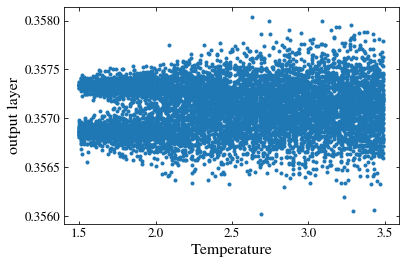

epoch = 365, training loss = 0.07233372


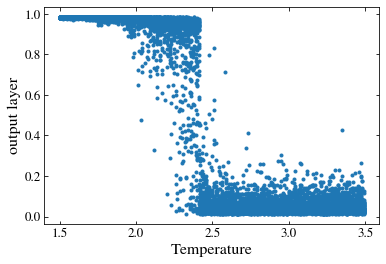

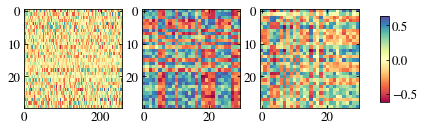

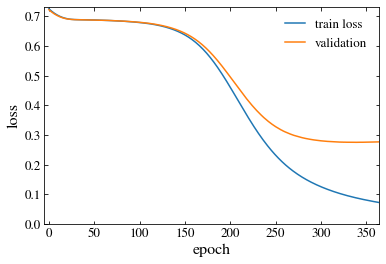

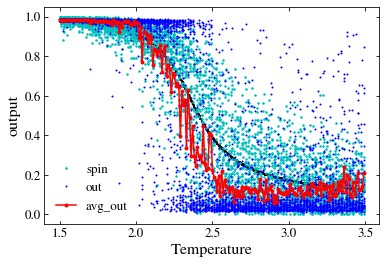

test loss = 0.28120217, accuracy = 0.89550000


In [15]:
Dmodel_sig = D_Classification(func = nn.Sigmoid, h_node = 30)

DNet(
  (W1): Linear(in_features=256, out_features=30, bias=False)
  (b1): Linear(in_features=30, out_features=1, bias=False)
  (W2): Linear(in_features=30, out_features=30, bias=False)
  (b2): Linear(in_features=30, out_features=1, bias=False)
  (W3): Linear(in_features=30, out_features=30, bias=False)
  (b3): Linear(in_features=30, out_features=1, bias=False)
  (W4): Linear(in_features=30, out_features=2, bias=False)
  (b4): Linear(in_features=2, out_features=1, bias=False)
  (activate): ReLU()
  (sig): Sigmoid()
)
epoch = 0, training loss = 0.74770153, accuracy = 0.50000000


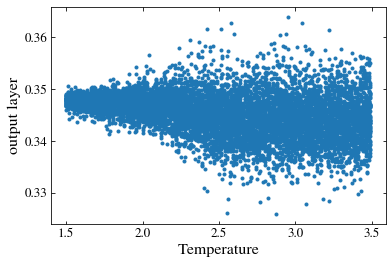

epoch = 122, training loss = 0.11166605


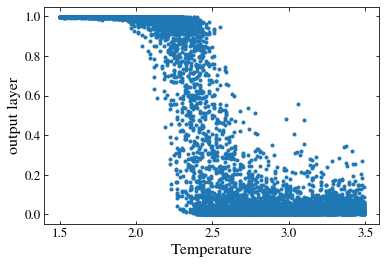

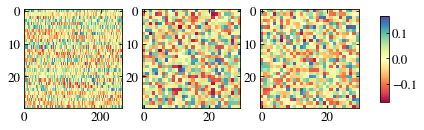

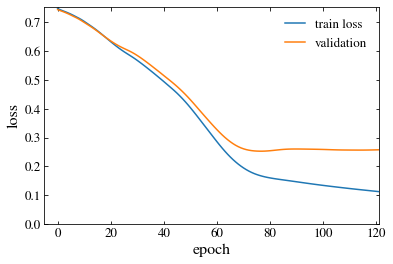

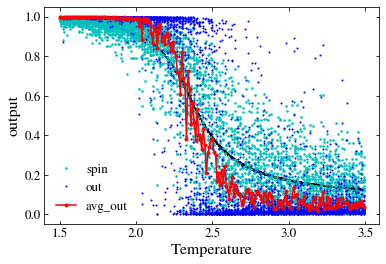

test loss = 0.24663237, accuracy = 0.92400000


In [16]:
Dmodel_relu = D_Classification(func = nn.ReLU, h_node = 30)

DNet(
  (W1): Linear(in_features=256, out_features=30, bias=False)
  (b1): Linear(in_features=30, out_features=1, bias=False)
  (W2): Linear(in_features=30, out_features=30, bias=False)
  (b2): Linear(in_features=30, out_features=1, bias=False)
  (W3): Linear(in_features=30, out_features=30, bias=False)
  (b3): Linear(in_features=30, out_features=1, bias=False)
  (W4): Linear(in_features=30, out_features=2, bias=False)
  (b4): Linear(in_features=2, out_features=1, bias=False)
  (activate): Tanh()
  (sig): Sigmoid()
)
epoch = 0, training loss = 0.71889979, accuracy = 0.49994436


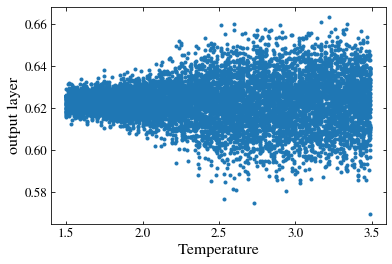

epoch = 165, training loss = 0.12445722


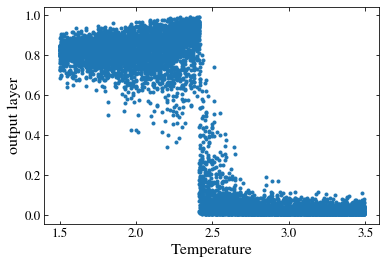

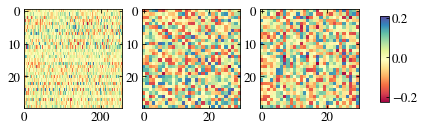

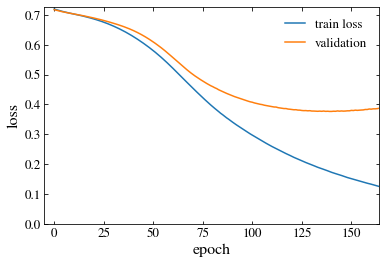

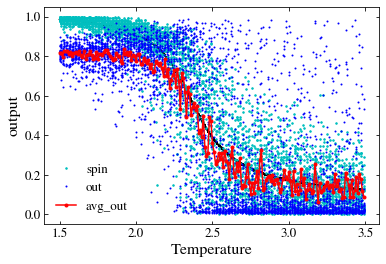

test loss = 0.36359006, accuracy = 0.87350000


In [17]:
Dmodel_tanh = D_Classification(func = nn.Tanh, h_node = 30)

In [18]:
torch.cuda.is_available()

False